# Lab 3: CNNs and Deep Learning

## TBMI26/732A55 Neural Networks and Learning Systems

### Michael Felsberg

## 2D Convolution
For the further steps, we often need to visualize an image and we define a shortcut for that:

In [8]:
from matplotlib import pyplot as plt
%matplotlib inline

def visualize(img):
    plt.imshow(img,'gray')
    plt.colorbar()
    plt.show()
    print('Image size:', img.shape)

Convolution can be performed in 2D using the function `scipy.signal.convolve2d()`.  

**Task 1:** Use this function to generate a 2D kernel of size $33\times33$ by five times cascading 2D convolutions of $h$ with itself, starting with $h = \begin{array}{|c|c|}
      \hline
      \frac{1}{4} & \frac{1}{4} \\
      \hline
      \frac{1}{4} & \frac{1}{4} \\
      \hline
    \end{array}$. Visualize the kernel.

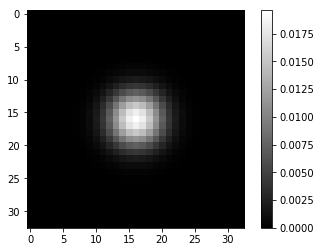

Image size: (33, 33)


In [12]:
import scipy
from scipy import signal
import numpy as np

h=np.array([[1/4,1/4],
          [1/4,1/4]])
for i in range(5):
    h = scipy.signal.convolve2d(h,h)
visualize(h)

**Task 2:** Now, load the image 'MR15^044.JPG' (a sample from ImageNet), convert it to gray-scale by summing its  R-, G-, and B-values at each pixel, and normalize it to the interval $[0;1]$. Convolve it with $h$ from the previous task with the options `'valid'` and `'same'`. Visualize all three images. What differences do you observe regarding the size and intensity of the output?

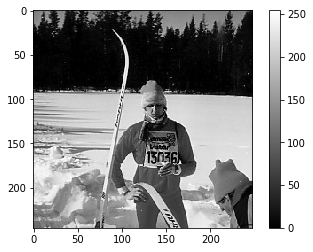

Image size: (246, 248)


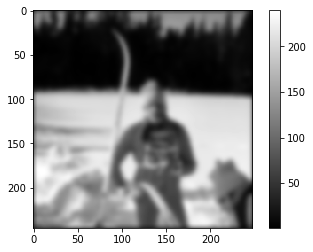

Image size: (246, 248)


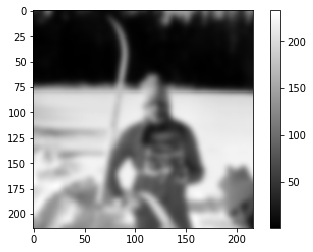

Image size: (214, 216)


In [22]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

im = plt.imread("MR15^044.JPG")
grayIm = rgb2gray(im)
valid = scipy.signal.convolve2d(grayIm,h,mode = 'valid')
same = scipy.signal.convolve2d(grayIm,h,mode = 'same')
visualize(grayIm)
visualize(same)
visualize(valid)

Strided convolution removes samples. According to the Nyquist theorem, this can generate aliasing artifacts.  

**Task 3:** Visualize the original gray-scale image and the output image from the previous task (with option `'same'`) with only keping every fifth row and column (stride 5). What do you observe, in particular at the ski?

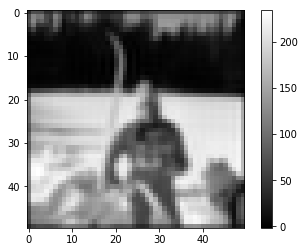

Image size: (50, 50)


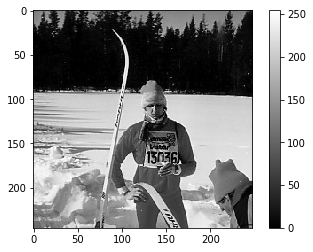

Image size: (246, 248)


In [28]:
deci = scipy.signal.decimate(same,5)
deci = scipy.signal.decimate(deci,5,axis=-2)
visualize(deci)
visualize(grayIm)

**Task 3 answer:**
The backgournd has been folded into the foreground.

## Convolution  in TensorFlow
We will now repeat the same steps in TensorFlow, where we will exploit its capability to perform *eager execution*. This is initialized as follows:

In [29]:
import tensorflow as tf

print('TensorFlow version '+tf.__version__)
tf.enable_eager_execution()
if tf.executing_eagerly():
    print('Eager execution activated!')

TensorFlow version 1.9.0
Eager execution activated!


TensorFlow allows to map from and to numpy. Also, operations are automatically casted. In order to get used to TensorFlow and the casting, we repeat the convolution 1.a) from class 5 (see Lisam). As you have learned in the lecture, any convolution with kernel $h$ can also be performed as matrix multiplication by the Toeplitz matrix $H$.

**Task 4:**  Use `scipy.linalg.toeplitz` to generate the matrix $H$ for the kernel $h= \begin{array}{|c|c|c|}
      \hline
      \hphantom{-}1 & \hphantom{-}\textbf{2} & -2 \\
      \hline
    \end{array}$ and boundary condition `'same'` and $f= \begin{array}{|c|c|c|c|c|c|c|c|}
      \hline
      \hphantom{-}1 & -1 & -2 & \hphantom{-}\textbf{0} & -1 & \hphantom{-}1 & \hphantom{-}2 & -1 \\
      \hline
    \end{array}$ in TensorFlow (`tf.constant()`). Multiply $H$ and $f$ and display the result. Verify that the result is the same as in 1.a). What are the respective classes of $H$, $f$, and the result?  
    Hints: `scipy.linalg.toeplitz` can take the first column and row as input; `[*np.zeros()]=np.zeros()` (`*` dereferences all elements of a tuple) 

In [54]:
H = scipy.linalg.toeplitz([2,-2,0,0,0,0,0,0],[2,1,0,0,0,0,0,0])
f = np.atleast_2d(tf.constant([1,-1,-2,0,-1,1,2,-1]))
f = tf.transpose(f)
H@f

<tf.Tensor: id=168, shape=(8, 1), dtype=int32, numpy=
array([[ 1],
       [-6],
       [-2],
       [ 3],
       [-1],
       [ 6],
       [ 1],
       [-6]], dtype=int32)>

Keras layers can be applied in eager mode using the `tf.keras.layers` package. **NOTE:**  `tf.keras.layers` and **NOT** `keras.layers`.

**Task 5:** Perform the convolution from the previous task using a convolution layer `Conv1D` and a (trivial) `Sequential` model from `tf.keras`.  
Hints: RTFM of `tf.keras.Sequential` - weights can be set for the model (list) or the layer (by traversing the layers list). Apply `use_bias=False` to avoid random DC-shifts.

In [86]:
model = tf.keras.Sequential()
model.set_weights([1,2,-2])
Conv1D_layer = tf.keras.layers.Conv1D(8,kernel_size=3,use_bias=False)
model.add(Conv1D_layer)
model.fit()
model.summary()
#model.apply(f)

ValueError: Please provide to Input either a `shape` or a `tensor` argument. Note that `shape` does not include the batch dimension.

**Task 6:** Apply the cascaded $33\times33$ filter from task 1 to the image from task 2 using a `Conv2D` layer. Compare the result visually and by subtracting the fitting result from task 2.

**Task 7:** Repeat the previous task with stride 5 and compare the result visually and by subtracting the fitting result from task 3. Repeat the task, but with a $1\times1$ filter (coefficient `1`) and stride 5. Compare again the result visually and by subtracting the fitting result from task 3.  
Hint: You might need to adjust the offset for the subsampling.

We now define a new filter that is, unlike $h$, anti-symmetric:

In [ ]:
fsz = 33
hfsz = 17
g = h*(np.expand_dims(np.arange(-hfsz+1,hfsz),1)@np.ones((1,fsz)))
visualize(g)

**Task 8:** repeat tasks 6 & 7 with $g$ instead of $h$. What difference do you observe and why?

## Training layers
We now take the input and output from task 6 as training data (input and output) for supervised learning of a convolution layer.  
**Task 9:** Although we only have a single input and output image, we can expect the training to work, although this usually requires multiple samples. Why? Define two tensors `batch` and `label` that contain the data from task 6.

**Task 10:** We want to apply the L1-loss. Define a suitable function `loss(model, x, y)` that can be used during training.

Training a layers requires computing the gradient. For TF in eager mode, we use `GradientTape()` for this purpose.  
**Task 11:** Train the model from task 6 (but without assigning the weights) using the data from task 9, the loss from task 10, and `GradientDescentOptimizer()`. During training, print the loss every 100 steps and visualize the learned kernel after training.  
Hint: add a kernel_constraint to be non-negative.

The result can be improved in several ways: data augmentation (e.g. by flipping the image, using the three RGB-channel separately), regularizing the weights (e.g. using the L1-norm), and replacing the optimizer (e.g., ADAM).  
**Extra task (not to be done before task 14 is completed):** Try to improve the result using one or several of the mentioned approaches.

## Training a whole network
So far, we have been training a single layer and we have been following the progress with the help of the Eager mode. If we want to train a whole network, it is much better to leave the Eager mode and to compile the graph. For this, we need to kill the notebook kernel ("Kernel" -> "Restart"). After that, we continue below in the classical TensorFlow mode.  

In [ ]:
import tensorflow as tf
print('TensorFlow version '+tf.__version__)
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

**Task 12:** We will train on CIFAR10, which is contained in `keras.datasets`. Download the dataset, show a sample for each class, convert the labels to one-hot coding, and normalize the images.

**Task 13:** Build the depicted LeNet5-inspired model using Keras standard components.
![title](model.png)

We will now train the network. For displaying the performance we define a helper function:

In [ ]:
def plot_model_history(model):
    line_w = 3
    fig_size = (8, 6)
    plt.figure(0)
    plt.plot(model.history['acc'],'r', lw=line_w)
    plt.plot(model.history['val_acc'],'b', lw=line_w)
    plt.rcParams['figure.figsize'] = fig_size
    plt.xlabel("Epoch number")
    plt.ylabel("Accuracy")
    plt.title("Training Accuracy vs Validation Accuracy")
    plt.legend(['Training','Validation'])
    plt.grid(True)

**Task 14:** Train the defined model for 50 epochs and a suitable batch size and display the result.

The results can be improved in several ways, e.g., by successively reducing the learning rate (divided by two after 30 and 40 epochs), by data augmentation (`ImageDataGenerator`), and by weight regularization (see above).  
**Extra task:** Try to improve the result using one or several of the mentioned approaches.  
Hint: you need to define a suitable callback function to change the learning rate during training.